Epoch 1/100


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.1055 - val_loss: 0.0050
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0147 - val_loss: 0.0041
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0275 - val_loss: 0.0099
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0159 - val_loss: 0.0049
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0149 - val_loss: 0.0029
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0143 - val_loss: 0.0019
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0135 - val_loss: 0.0015
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0155 - val_loss: 0.0018
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0198 - val_loss: 0.0014
Epoch 10/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0135 - val_loss: 0.0021
Epoch 11/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0072 - val_loss: 8.8111e-04
Epoch 12/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss:

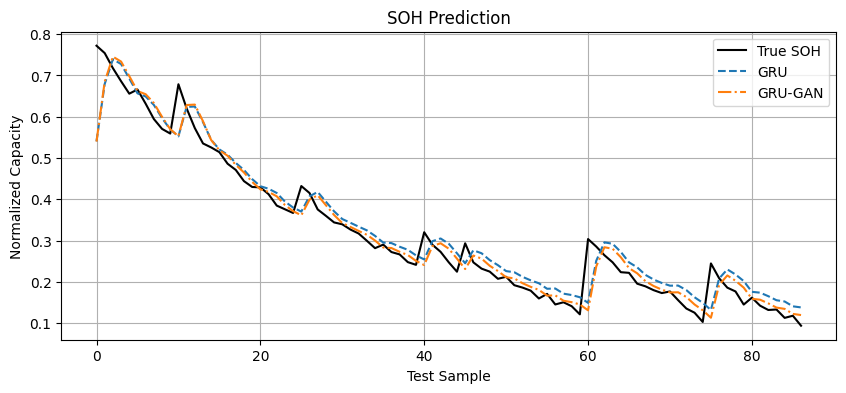

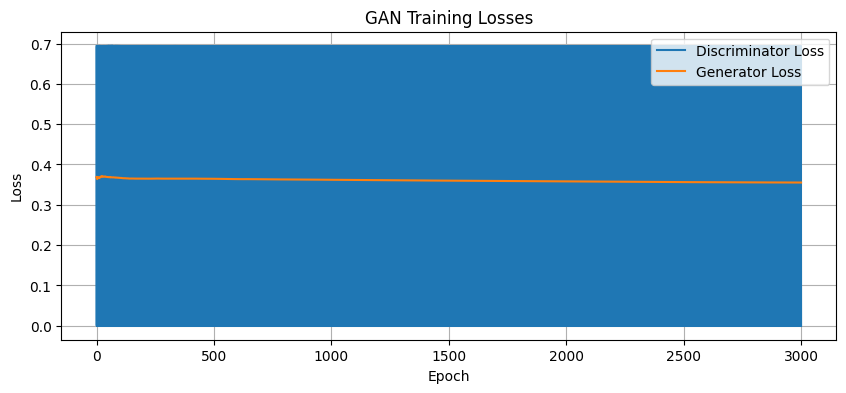

In [4]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, GRU, Dropout, Dense, LeakyReLU, BatchNormalization, Add
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.io import loadmat
import matplotlib.pyplot as plt

# --- Data loading and extraction ---
def extract_capacity(mat, key):
    try:
        battery = mat[key][0, 0]
        cycles = battery['cycle'][0]
    except Exception as e:
        print(f"Error loading cycles from {key}:", e)
        return np.array([])

    capacities = []
    for cyc in cycles:
        try:
            ctype = cyc['type'][0]
            if isinstance(ctype, bytes):
                ctype = ctype.decode()
            if ctype == 'discharge':
                cap = cyc['data']['Capacity']
                cap_val = cap[0][0] if cap.size == 1 else np.mean(cap)
                capacities.append(cap_val)
        except:
            continue
    return np.array(capacities).flatten()

mat5 = loadmat("B0005.mat")
mat18 = loadmat("B0018.mat")
cap5 = extract_capacity(mat5, "B0005")
cap18 = extract_capacity(mat18, "B0018")

capacity_series = np.concatenate([cap5, cap18]).astype(float)
scaler = MinMaxScaler()
capacity_scaled = scaler.fit_transform(capacity_series.reshape(-1, 1)).flatten()

seq_length = 10
X, y = [], []
for i in range(len(capacity_scaled) - seq_length):
    X.append(capacity_scaled[i:i+seq_length])
    y.append(capacity_scaled[i+seq_length])
X, y = np.array(X), np.array(y)

split_idx = int(len(X)*0.7)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]
X_train_gru = X_train.reshape(-1, seq_length, 1)
X_test_gru = X_test.reshape(-1, seq_length, 1)

# --- GRU model ---
gru_model = Sequential([
    GRU(100, return_sequences=True, input_shape=(seq_length,1)),
    Dropout(0.2),
    GRU(100),
    Dropout(0.2),
    Dense(1)
])
gru_model.compile(optimizer='adam', loss='mse')
gru_model.fit(X_train_gru, y_train, 
              validation_split=0.2,
              epochs=100, batch_size=16,
              callbacks=[EarlyStopping(patience=10, restore_best_weights=True)],
              verbose=1)
gru_model.trainable = False

gru_pred_train = gru_model.predict(X_train_gru)
gru_pred_test = gru_model.predict(X_test_gru)

# --- Deeper Residual Generator ---
def build_deep_residual_generator():
    inp = Input(shape=(1,))
    x = Dense(512)(inp)
    x = LeakyReLU(0.2)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    x = Dense(512)(x)
    x = LeakyReLU(0.2)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    x = Dense(256)(x)
    x = LeakyReLU(0.2)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    x = Dense(128)(x)
    x = LeakyReLU(0.2)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    delta = Dense(1)(x)
    out = Add()([inp, delta])
    return Model(inp, out)

# --- Deeper Discriminator ---
def build_deeper_discriminator():
    inp = Input(shape=(1,))
    x = Dense(256)(inp)
    x = LeakyReLU(0.2)(x)
    x = Dropout(0.4)(x)
    x = Dense(256)(x)
    x = LeakyReLU(0.2)(x)
    x = Dropout(0.4)(x)
    x = Dense(128)(x)
    x = LeakyReLU(0.2)(x)
    x = Dropout(0.4)(x)
    out = Dense(1, activation='sigmoid')(x)
    model = Model(inp, out, name="DeeperDiscriminator")
    model.compile(optimizer=Adam(5e-5), loss='binary_crossentropy', metrics=['accuracy'])
    return model

generator = build_deep_residual_generator()
generator.compile(optimizer='adam', loss='mse')
generator.fit(gru_pred_train, y_train, epochs=100, batch_size=32, verbose=1)

discriminator = build_deeper_discriminator()
discriminator.trainable = False

gan_input = Input(shape=(1,))
gan_output = discriminator(generator(gan_input))
combined = Model(gan_input, [gan_output, generator(gan_input)])
combined.compile(optimizer=Adam(5e-5), loss=['binary_crossentropy', 'mse'], loss_weights=[0.5, 0.5])

# --- GAN training loop ---
epochs = 3000
batch_size = 32
real_labels = np.ones((batch_size, 1))
fake_labels = np.zeros((batch_size, 1))

d_losses, g_losses = [], []
for epoch in range(epochs):
    idx = np.random.randint(0, X_train.shape[0], batch_size)
    real_soh = y_train[idx].reshape(-1, 1)
    gru_input = X_train_gru[idx]
    gru_preds = gru_model.predict(gru_input, verbose=0)
    fake_soh = generator.predict(gru_preds, verbose=0)

    if epoch % 2 == 0:
        discriminator.trainable = True
        d_loss_real = discriminator.train_on_batch(real_soh, real_labels)
        d_loss_fake = discriminator.train_on_batch(fake_soh, fake_labels)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
    else:
        d_loss = [0, 0]

    discriminator.trainable = False
    g_loss = combined.train_on_batch(gru_preds, [real_labels, real_soh])

    d_losses.append(d_loss[0])
    g_losses.append(g_loss[0])

    if (epoch + 1) % 100 == 0:
        print(f"Epoch {epoch+1} | D Loss: {d_loss[0]:.4f} | G Loss: {g_loss[0]:.4f}")

# --- Evaluation ---
y_pred_gru = gru_model.predict(X_test_gru).flatten()
y_pred_gan = generator.predict(y_pred_gru.reshape(-1, 1)).flatten()

rmse_gru = np.sqrt(mean_squared_error(y_test, y_pred_gru))
rmse_gan = np.sqrt(mean_squared_error(y_test, y_pred_gan))
mae_gru = mean_absolute_error(y_test, y_pred_gru)
mae_gan = mean_absolute_error(y_test, y_pred_gan)
r2_gru = r2_score(y_test, y_pred_gru)
r2_gan = r2_score(y_test, y_pred_gan)

print(f"GRU       -> RMSE: {rmse_gru:.4f}, MAE: {mae_gru:.4f}, R2: {r2_gru:.4f}")
print(f"GRU-GAN   -> RMSE: {rmse_gan:.4f}, MAE: {mae_gan:.4f}, R2: {r2_gan:.4f}")

# --- Plots ---
plt.figure(figsize=(10,4))
plt.plot(y_test, label="True SOH", color='black')
plt.plot(y_pred_gru, label="GRU", linestyle='--')
plt.plot(y_pred_gan, label="GRU-GAN", linestyle='-.')
plt.title("SOH Prediction")
plt.xlabel("Test Sample")
plt.ylabel("Normalized Capacity")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10,4))
plt.plot(d_losses, label='Discriminator Loss')
plt.plot(g_losses, label='Generator Loss')
plt.title("GAN Training Losses")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()